# CrossValidation: fitting formulas for Coupled Dark Energy

## Import Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time

In [2]:
from looti import dictlearn as dcl
from looti import datahandle as dhl
from looti import PlottingModule as pm
from looti import tools as too
from looti import automatic_validation as av

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Import Data

The data is imported from pandas Dataframes which have been previously created using the `read_files` module.
The DataFrames contain the **k-grid** and the **power spectrum** at each redshift and each parameter variation, for the *extended model* and the *reference model*.

### Specify Paths

The DataFrames of the *extented model* and the *reference model* should be stored inside the same `data_folder`. The results of the experiments(plots, interpolation functions) are stored inside `the results_folder`

In [4]:
data_folder = '../../SimulationData/CDE_fitting_formulae/'
results_folder = './results/'

In [5]:
too.mkdirp(results_folder)    ## If directory does not exists, it is created here

### Load CoupledDE dataframes

The user has **two options** : provide the power **spectra** of the *extended* and *reference model* **OR** provide directly the **ratios** between these two models.

**Case 1** (spectra): user provides :
- datafile_ext : filename containing the power spectra of the extended model
- datafile_ref : filename containing the power spectra of the reference model (i.e. LCDM)

**Case 2** (ratios): user provides :
- datafile_ext : filename containing the ratios between the extended model and the reference model

In [6]:
###Name of the file for the external input data, without the extension
datafile_ext = 'EXP_Pk_32_betas_60_redzs'
###Name of the file for the LCDM input data
datafile_ref = 'LCDM_Pk_60_redzs'

The following functions load the data into a object `emulation_data`. When the ratios are directly provide the user must indicate : `ratio_mode=True`
The function `calculate_ratio_by_redshifts` computes the ratio between the *extended* and *reference* model at each **redshit** passed as argument.

In [7]:
## Specify paths and the number of free cosmological parameters to interpolate
emulation_data = dhl.DataHandle( datafile_ext, data_folder, datafile_ref, num_parameters=1) 
emulation_data.read_csv_pandas() 
emulation_data.calculate_ratio_by_redshifts(emulation_data.z_vals, normalize=False)

/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:245: PerformanceWarning: indexing past lexsort depth may impact performance.


## Calculate power spectra ratios at all redshifts available

Available **redshifts** are stored in the attribute `z_vals`

In [8]:
# Available redshifts
emulation_data.z_vals

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
       2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
       2.75, 2.8 , 2.85, 2.9 , 2.95])

The function `calculate_ratio_by_redshifts` computes the ratio between the *extended* and *reference* model at each **redshit** passed as argument.

The user can optionally decide to **normalize** the data by passing `normalize=False`. This option will force all the ratios to be equal to 1 at k = `pos_norm`

In [9]:
## Set normalize=False, since Fitting Formulae are already normalized
## First argument contains all the redshifts at which simulations are available
emulation_data.calculate_ratio_by_redshifts(emulation_data.z_vals, normalize=False)

# Import hyperparameters

The `Crossvalidation_folder`should contains the results of crossvalidations for different methods.
Each of the results are stored into a csv file, *for e.g GP_hyperparameter_file*.

The crossvalidation can be perfomed by a crossvalidation script that can be run on plateform such as Galileo.

In [10]:
##Folder with Crossvalidation's results 
Crossvalidation_folder = "../../SimulationData/CrossValidationResults/CDE_fitting_formulae/" 
##file for each methods
    ##GP:
GP_hyperparameter_file = "GP_crossvalidation_FittFormula.csv"
    ##PCA:
PCA_hyperparameter_file = "PCA_crossvalidation_FittFormula.csv"

In [11]:
## Read the CSV FILE
GP_hyperparameter = pd.read_csv(Crossvalidation_folder+GP_hyperparameter_file )
PCA_hyperparameter = pd.read_csv(Crossvalidation_folder+ PCA_hyperparameter_file)

## Define Parameters 

### Define a mask

The user can defined a **mask**. Usually, the mask is simply ignoring extremal values `(max_k_grid ,min_k_grid )`.

In [12]:
##Change here the value of the grid
max_k_grid = 10 ##any k above this value would then be ignored
min_k_grid = 0.1##any k below this value would then be ignored

linkgrid = emulation_data.lin_k_grid # Linear k-grid 
#The mask is defined here. The user should not change anything, except if a personalised mask is wanted.
mask = [k for k in np.where(linkgrid <max_k_grid)[0] if k in np.where(linkgrid >min_k_grid)[0]] 
GLOBAL_applymask = True ##False would ignore the mask

### Define RMSE's hyperparameters 

The **RMSE** is computed by the function `av.RMSE_dictionary` that returns a frame with the RMSE associated with the number of training vectors. That number vary between the number of minimum and maximum training vectors specified by the user.


At each call of the function, a **random set of test vectors** is chosen. Thus different calls of the function would not lead to the same plots. In order to have relevant statics, these plots can be averaged over different realisations. The user can choose the number of realisations with `n_run`

In [13]:
n_run = 1 ## The number of realisations for the RMSE. Large numbers lead to better statistics.

In [14]:
wanted_ntest = 10 ## Number of test vectors

max_ntrain = 20 ## Maximum number of train vectors 
min_ntrain = 3 ## Minimum number of train vectors 

redshift_index =[0] ##Redshift indice 

GP_crossval_df_dict_mingroup = {"theo":GP_hyperparameter} ##GP hyperparameters'dictionary 
PCA_crossval_df_dict_mingroup = {"theo":PCA_hyperparameter}##PCA hyperparameters'dictionary 

##The user must be specified which methods should not be turned off
turnoff_PCA = False 
turnoff_GP = False

### Compute RMSE(s)

In [15]:
list_datatest =[]
for i in range(n_run):
    datatest = av.RMSE_dictionary(emulation_data=emulation_data,
                                  wanted_ntest=wanted_ntest,
                                  max_ntrain=max_ntrain,min_ntrain=min_ntrain,
                                  redshift_index = redshift_index,
                                  GP_crossval_df_dict_mingroup=GP_crossval_df_dict_mingroup,
                                  turnoff_GP = False,
                                  PCA_crossval_df_dict_mingroup=PCA_crossval_df_dict_mingroup,
                                  turnoff_PCA=False,
                                  number_of_splits=1,
                                  thinning=1,mask=mask ,split_run_ind = 0,GLOBAL_applymask = GLOBAL_applymask )
    list_datatest.append(datatest)

/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 4
numtr 3
++++theo
PCA :  1
('Shape of PCA matrix: (4, 1)',)
('Number of PCA components: 1',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 5
numtr 4
++++theo
PCA :  4
('Shape of PCA matrix: (5, 4)',)
('Number of PCA components: 4',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 6
numtr 5
++++theo
PCA :  5
('Shape of PCA matrix: (6, 5)',)
('Number of PCA components: 5',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 7
numtr 6
++++theo
PCA :  2
('Shape of PCA matrix: (7, 2)',)
('Number of PCA components: 2',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 8
numtr 7
++++theo
PCA :  7
('Shape of PCA matrix: (8, 7)',)
('Number of PCA components: 7',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 9
numtr 8
++++theo
PCA :  6
('Shape of PCA matrix: (9, 6)',)
('Number of PCA components: 6',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 10
numtr 9
++++theo
PCA :  5
('Shape of PCA matrix: (10, 5)',)
('Number of PCA components: 5',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 11
numtr 10
++++theo
PCA :  4
('Shape of PCA matrix: (11, 4)',)
('Number of PCA components: 4',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 12
numtr 11
++++theo
PCA :  10
('Shape of PCA matrix: (12, 10)',)
('Number of PCA components: 10',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 13
numtr 12
++++theo
PCA :  11
('Shape of PCA matrix: (13, 11)',)
('Number of PCA components: 11',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 14
numtr 13
++++theo
PCA :  9
('Shape of PCA matrix: (14, 9)',)
('Number of PCA components: 9',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 15
numtr 14
++++theo
PCA :  14
('Shape of PCA matrix: (15, 14)',)
('Number of PCA components: 14',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 16
numtr 15
++++theo
PCA :  14
('Shape of PCA matrix: (16, 14)',)
('Number of PCA components: 14',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 17
numtr 16
++++theo
PCA :  12
('Shape of PCA matrix: (17, 12)',)
('Number of PCA components: 12',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 18
numtr 17
++++theo
PCA :  17
('Shape of PCA matrix: (18, 17)',)
('Number of PCA components: 17',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 19
numtr 18
++++theo
PCA :  15
('Shape of PCA matrix: (19, 15)',)
('Number of PCA components: 15',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/datahandle.py:336: PerformanceWarning: indexing past lexsort depth may impact performance.


('number of wanted test vectors', 10)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
Train Size 20
numtr 19
++++theo
PCA :  17
('Shape of PCA matrix: (20, 17)',)
('Number of PCA components: 17',)


## Plot the average RMSE for each method

The RMSE is plotted by `plot_RMSE` function. If `n_run` > 1 then the RMSEs are average over the different realisation.

/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/PlottingModule.py:324: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/looti-0.0.0-py3.7.egg/looti/PlottingModule.py:328: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


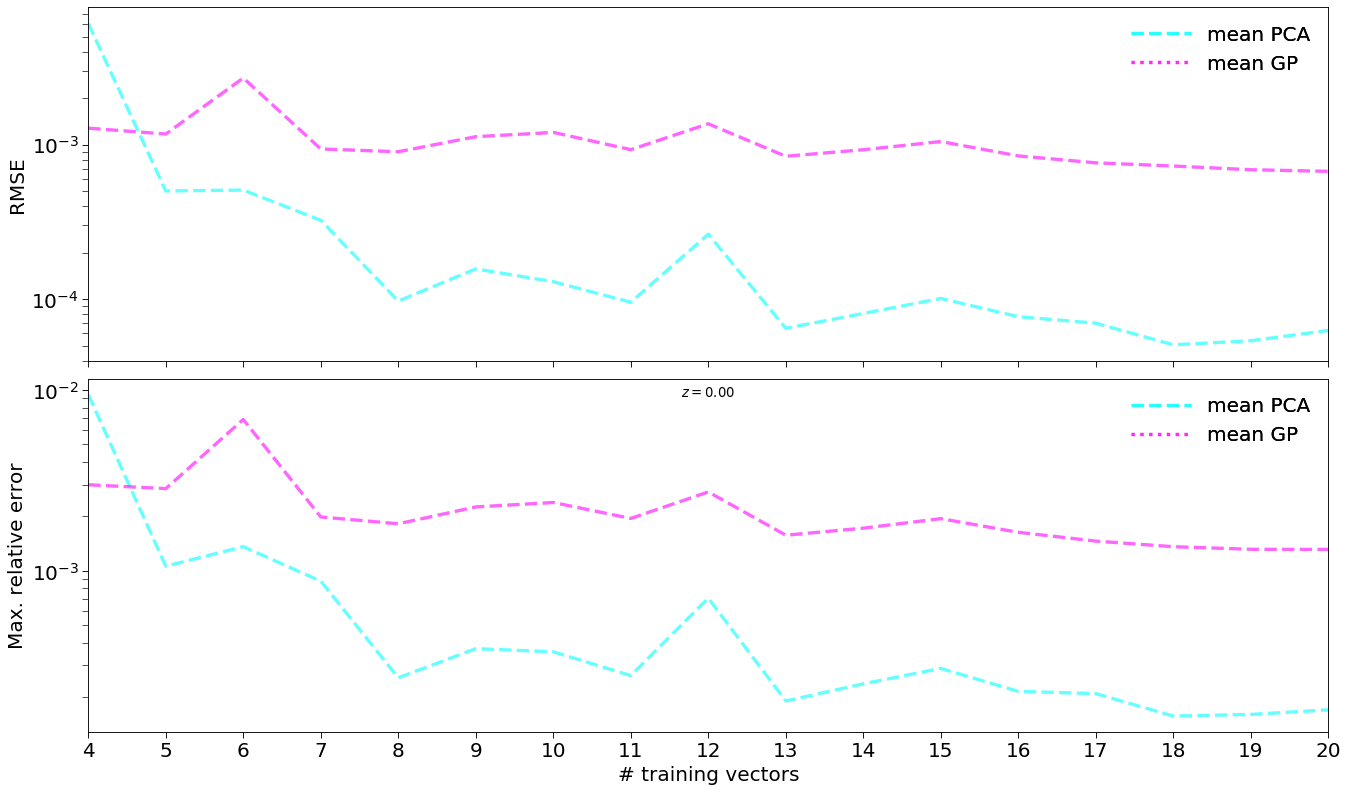

In [16]:
pm.plot_RMSE(0,list_datatest,noi='theo',turnoff_PCA=turnoff_PCA,turnoff_GP=turnoff_GP,
             y_scale_log= True )##log scale for the y axis)